# CSCI 3202, Spring 2022: Final Coding Project

---


This is your final programming project for CSCI 3202. It is due on Canvas by **11:59 PM on Saturday April 30**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

You have two options for completing your final project for this course. The first option is presented in this notebook and involves implementing a reinforcement learning algorithm and producing a five-minute video that explains your process of solving this problem. The second option is to design your own project that includes the algorithms we've discussed since the midterm - Bayes Nets, Hidden Markov Models, Markov Decision Processes, or Reinforcement Learning - or an algorithm related to one of these that we haven't discussed in class. Your project also needs to include some kind of analysis of how it performed on a specific problem. If you're interested in the design your own project option, you need to discuss your idea with one of the course instructors to get approval. If you do a project without getting approval, you will receive a 0 regardless of the quality of the project. You will also need to produce a short, five-minute video that explains your project.

**The rules:**

1. Choose EITHER the given problem to submit OR choose your own project topic. 

2. If you choose your own project topic, please adhere to the following guidelines:
- The project needs to be approved by the course instructors.
- The project needs to include one of the algorithms we've discussed since the midterm - Bayes Nets, HMMs, MDPs, or Reinforcement Learning - or an algorithm that we haven't discussed in class. 
- If you do your own project without prior approval, you will receive a 0 for this project.
- Your project code, explanation, and results must all be contained in a Jupyter notebook. 

3. All work, code and analysis must be **your own**.
4. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python. You may not use entire segments of code as solutions to any part of this project, e.g. if you find a Python implementation of policy iteration online, you can't use it.
5. You may **not** post to message boards or other online resources asking for help.
6. **You may not collaborate with classmates or anyone else.**
7. This is meant to be like a coding portion of your final exam. So, we will be much less helpful than we typically am with homework. For example, we will not check answers, help debug your code, and so on.
8. If you have a question, post it first as a **private** Piazza message. If we decide that it is appropriate for the entire class, then we will make it a public post (and anonymous).
9. If something is left open-ended, it is probably because we intend for you to code it up however you want, and only care about the plots/analysis we see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name:** Ryan Coe

---



In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors



---
## [100 pts] Problem 1:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if the drone is at $(x,y,z)$ it means that the box is centered at $(x,y,z)$. There are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. For example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a living reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the landing pad is, and how to get there from any initial state.

Before moving on to Part B, we recommend that you test that your MDPLanding code is set up correctly. Write unit tests that display the actions for a given state, rewards, results, etc. This will help you identify errors in your implementation and save you a lot of debugging time later.

In [3]:
class MDPLanding:
    def __init__(self, L):
        self.states = []
        self.terminal_states = dict()
        self.default_reward = -0.01
        self.all_actions = ['Up','Down','North','South','East','West']
        self.discount = .999
        self.L = L
        for i in range(L+1):
            for j in range(L+1):
                for k in range(L+1):
                    self.states.append((i,j,k))
        for i in self.states:
            if i[2] == 0:
                if i[0] == L/2 and i[1] == L/2:
                    self.terminal_states[i] = 1
                else:
                    self.terminal_states[i] = -1
                    
    def actions(self, state):
        poss_states = []
        if state[2] != 0:
            poss_states.append(self.all_actions[1])
        if state[1] != self.L:
            poss_states.append(self.all_actions[2])
        if state[1] != 0:
            poss_states.append(self.all_actions[3])
        if state[0] != self.L:
            poss_states.append(self.all_actions[4])
        if state[0] != 0:
            poss_states.append(self.all_actions[5])
        if state[2] != self.L:
            poss_states.append(self.all_actions[0])
        return poss_states
    
    def reward(self, state):
        if state in self.terminal_states:
            return self.terminal_states[state]
        else:
            return self.default_reward
    
    def result(self, state, action):
        if action == self.all_actions[0]:
            state = (state[0], state[1], state[2]+1)
        elif action == self.all_actions[1]:
            state = (state[0], state[1], state[2]-1)
        elif action == self.all_actions[2]:
            state = (state[0], state[1]+1, state[2])
        elif action == self.all_actions[3]:
            state = (state[0], state[1]-1, state[2])
        elif action == self.all_actions[4]:
            state = (state[0]+1, state[1], state[2])
        elif action == self.all_actions[5]:
            state = (state[0]-1, state[1], state[2])
        else:
            print("Action not recognised")
        return state

t = MDPLanding(10)
print(t.states)
print(t.actions((0,1,1)))
print(t.result((0,1,1),'East'))

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 0, 8), (0, 0, 9), (0, 0, 10), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 1, 10), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 2, 9), (0, 2, 10), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), (0, 3, 8), (0, 3, 9), (0, 3, 10), (0, 4, 0), (0, 4, 1), (0, 4, 2), (0, 4, 3), (0, 4, 4), (0, 4, 5), (0, 4, 6), (0, 4, 7), (0, 4, 8), (0, 4, 9), (0, 4, 10), (0, 5, 0), (0, 5, 1), (0, 5, 2), (0, 5, 3), (0, 5, 4), (0, 5, 5), (0, 5, 6), (0, 5, 7), (0, 5, 8), (0, 5, 9), (0, 5, 10), (0, 6, 0), (0, 6, 1), (0, 6, 2), (0, 6, 3), (0, 6, 4), (0, 6, 5), (0, 6, 6), (0, 6, 7), (0, 6, 8), (0, 6, 9), (0, 6, 10), (0, 7, 0), (0, 7, 1), (0, 7, 2), (0, 7, 3), (0, 7, 4), (0, 7, 5), (0, 7, 6), (0, 7, 7), (0, 7, 8), (0, 7, 9), (0, 7, 10), (0, 8, 0), (0, 8, 1), (

#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and **comment on the results**:
1. $(2,2,1)$ **Expected:** Down **Result:** Down - util: 1
1. $(0,2,1)$ **Expected:** East **Result:** East - util: .978
1. $(2,0,1)$ **Expected:** North **Result:** North - util: .978

**Comment:** The results were as expected. Nodes lower and closer to the center have a higher utility. The drone seems to take a path of dropping down to the level above the terminating states and then it navigates to the center and lands on the pad.

The policy for each of these states is the action that the agent should take in that state. 

In [4]:
def policy_evaluation(MDP, state, last_val):
    value = -1000
    action = ''
    for x in MDP.actions(state):
        newState = MDP.result(state, x)
        if newState not in MDP.terminal_states:
            newValue = MDP.reward(newState)+MDP.discount*(last_val[newState])
        else:
            newValue = MDP.reward(newState)
        if newValue > value:
            value = newValue
            action = x
    return value, action

def policy_iter(MDP, num = 50):
    last_val = dict()
    V = dict()
    A = dict()
    for i in MDP.states:
        last_val[i] = 0
    for x in range(num):
        for i in MDP.states:
            V[i], A[i] = policy_evaluation(MDP, i, last_val)
        last_val = V.copy()
    return V, A

def trace_path(state, L):
    v = 0
    MDP = MDPLanding(L)
    value, action = policy_iter(MDP)
    while v != 1:
        print("State: " + str(state) + ", Optimal Policy: " + action[state] + ", Policy Utility: " + str(value[state]))
        v = value[state]
        state = MDP.result(state, action[state])
        if state in MDP.terminal_states:
            break
    

trace_path((2,2,1),4)
print('Reached Goal')
trace_path((0,2,1),4)
print('Reached Goal')
trace_path((2,0,1),4)
print('Reached Goal')
#trace_path((3,4,4),4)
#print('Reached Goal')
trace_path((0,0,10),20)

State: (2, 2, 1), Optimal Policy: Down, Policy Utility: 1
Reached Goal
State: (0, 2, 1), Optimal Policy: East, Policy Utility: 0.978011
State: (1, 2, 1), Optimal Policy: East, Policy Utility: 0.989
State: (2, 2, 1), Optimal Policy: Down, Policy Utility: 1
Reached Goal
State: (2, 0, 1), Optimal Policy: North, Policy Utility: 0.978011
State: (2, 1, 1), Optimal Policy: North, Policy Utility: 0.989
State: (2, 2, 1), Optimal Policy: Down, Policy Utility: 1
Reached Goal
State: (0, 0, 10), Optimal Policy: Down, Policy Utility: 0.6854260659599026
State: (0, 0, 9), Optimal Policy: Down, Policy Utility: 0.6961221881480507
State: (0, 0, 8), Optimal Policy: Down, Policy Utility: 0.706829017165216
State: (0, 0, 7), Optimal Policy: Down, Policy Utility: 0.7175465637289449
State: (0, 0, 6), Optimal Policy: Down, Policy Utility: 0.7282748385675124
State: (0, 0, 5), Optimal Policy: Down, Policy Utility: 0.7390138524199323
State: (0, 0, 4), Optimal Policy: Down, Policy Utility: 0.7497636160359683
State:

#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values.  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. We refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [5]:
import random

def greedyPolicy(MDP, Q, state, epsilon):
    bestPolicy = max(Q[state], key=Q[state].get)
    randPolicy = []
    for x in MDP.actions(state):
        if x != bestPolicy:
            randPolicy.append(x)
    epsilonPolicy = randPolicy[0]
    for y in randPolicy:
        if Q[state][y] >= Q[state][epsilonPolicy]:
            epsilonPolicy = y
    return np.random.choice([bestPolicy,epsilonPolicy], p = [1-epsilon, epsilon])
    

def q_learning(MDP, num, epsilon, rate, arr = []):
    policy = ''
    means = []
    total_reward = 0
    prev_x = 0
    Q = dict()
    for i in MDP.states:
        Q[i] = dict()
        for j in MDP.actions(i):
            Q[i][j] = 0
    for x in range(num):
        state = random.choice(MDP.states)
        for y in range(50):
            policy = greedyPolicy(MDP, Q, state, epsilon)
            newState = MDP.result(state, policy)
            reward = MDP.reward(newState)
            total_reward += MDP.discount*reward
            newPolicy = max(Q[newState], key=Q[newState].get)
            Q[state][policy] += rate * reward+(MDP.discount * Q[newState][newPolicy]) - Q[state][policy]
            if newState in MDP.terminal_states:
                break
            state = newState
        if x+1 in arr:
            mean = total_reward/(x+1-prev_x)
            means.append(mean)
            print("Mean Cumulative Reward for " + str(prev_x+1)+" to "+str(x+1) + " Trials: " + str(mean))
            total_reward = 0
            prev_x = x+1
    return Q, means
count = 5000
q = q_learning(MDPLanding(10),count,.2,.1)
#print(q[0])

#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your code.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

Mean Cumulative Reward for 1 to 500 Trials: -0.4868126999996749
Mean Cumulative Reward for 501 to 1000 Trials: 0.47094858000008766
Mean Cumulative Reward for 1001 to 1500 Trials: 0.6585208200000193
Mean Cumulative Reward for 1501 to 2000 Trials: 0.6831361800000144
Mean Cumulative Reward for 2001 to 2500 Trials: 0.7000392599999977
Mean Cumulative Reward for 2501 to 3000 Trials: 0.6886906199999946
Mean Cumulative Reward for 3001 to 3500 Trials: 0.7231960799999901
Mean Cumulative Reward for 3501 to 4000 Trials: 0.713505779999997
Mean Cumulative Reward for 4001 to 4500 Trials: 0.7366226399999882
Mean Cumulative Reward for 4501 to 5000 Trials: 0.7408384199999887


Text(0.5, 0, 'Episode Intervals')

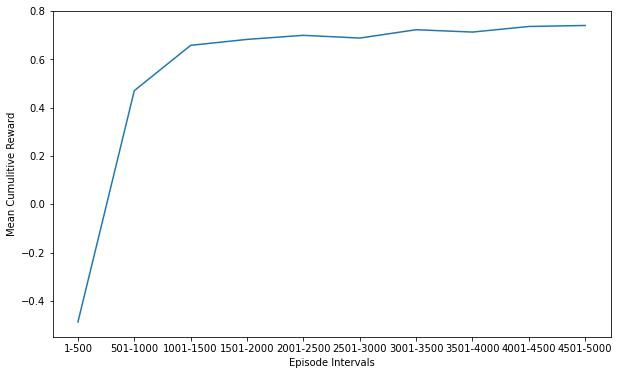

In [6]:
arr = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000]
q, arr2 = q_learning(MDPLanding(10),arr[len(arr)-1],.2,.1,arr)
plt.figure(figsize=(10, 6))
plt.plot(['1-500','501-1000','1001-1500','1501-2000','2001-2500','2501-3000','3001-3500','3501-4000','4001-4500','4501-5000'], arr2)
plt.ylabel('Mean Cumulitive Reward')
plt.xlabel('Episode Intervals')

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

The drone starts off with an empty Q dict, because of this there is very little information guiding the drone so it will spend more time flying around accumulating -.01 living utility and -1 terminating utility. However as the trials go on and the utility for spaces near the landing pad increase, the drone will have a better idea of where to go and it will start to accumulate more positive utility.

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

With an epsilon of .2 it will be very difficult to increase the accuracy to more than 1-epsilon or .8. This is because even if the drone always knows where the next best space is, it will miss the optimal policy 20% of the time. If we decrease the epsilon to .1 it is possible to gather scores above .8, but with that epsilon value the drones reliability plateaus once again at .9. In the end the highest score we can expect to achieve through q learning is 1-epsilon.

#### Part F
Choose three other reward structures, including the terminal rewards and the living rewards, and rerun your policy iteration and Q-learning algorithms with those reward structures. Write a paragraph or two describing the reward structures that you selected, what impact you expected the changes to have on your results, and what changes actually happened. If there was a difference in what you expected and what actually happened, reflect on why there was a difference. 

**Reward Structure 1:** Positive living reward

**Expected:** I believe that using a positive living reward will incentivise the drone to remain in non terminal states instead of seeking the shortest path to the landing pad.

**Result:** The mean cumulative reward starts off initially positive, around .15. The graph of mean rewards showed the same growth pattern as the original reward structure, however, the graph of the new reward structure plateaus at around .5 mean cumulative reward and it takes almost double the trials to get there. This does suggest that my initial expectation was correct as far fewer q trials reached a terminating state than the results of the initial reward structure.

**Reward Structure 2:** Bad terminal states incentive is positive but 1/4 of landing pad

**Expected:** Positions far from the center will have greater incentive to land off the pad instead of seeking the middle.

**Result:** With the original living reward there was no change to the drones incentive to seek the landing pad, however, after changing the living reward to -.1 instead of -.01 the drone was willing to land in terminal states other than the landing pad. Because the living reward was substantially higher the results from the mean cumulative reward graph were all lower. Despite this the graph shared the same growth pattern as the original reward structure. Similar to the first reward structure I tested, this structure also took longer to plateau by about 1000 trials.

**Reward Structure 3:** Terminal state reward multiplied by 10

**Expected:** The drone will do whatever it can to avoid landing on terminal states other than the landing pad. I believe the means will take longer to converge/plateau because they will try to avoid the epsilon chance they are moved randomly onto a bad terminal state.

**Result:** The policy iteration was unchanged by the new reward structure. This is likely because there is no random chance of making the wrong move and the goal is always prioritized. However, there were differences with the q learning. The initial mean reward was around -3 or -4 and it grew to plateau around .6. This reward structure converged much faster than any of the other structure, this makes sense because of how heavily penalized the drone is before it starts to terminate on the landing pad.
